# Exercice 3: Mise en place de notre modèle

Nous allons utiliser la bibliothèque ```spacy``` afin d'entraîner un modèle sur les données fournies. 

In [2]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy_irrelevant, format_data_as_spacy_others, format_data_as_spacy
from src.spacy_helper import get_spacy_irrelevant_model, get_spacy_others_model, get_spacy_model
from src.spacy_helper import train, predict, predict_with_threshold

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [3]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train, 10, test=(X_test, y_test))
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.119579209029325 test score:44.01422946745544%
Iteration 1/10. train_loss: 1.0461801884666784 test score:59.44462732602934%
Iteration 2/10. train_loss: 0.23308397168875672 test score:64.7567094366824%
Iteration 3/10. train_loss: 0.07505321239841578 test score:70.6165957700024%
Iteration 4/10. train_loss: 0.032053121332864976 test score:72.38755327195176%
Iteration 5/10. train_loss: 0.024005681379321686 test score:73.61869318623036%
Iteration 6/10. train_loss: 0.020258386465911826 test score:75.65786267615458%
Iteration 7/10. train_loss: 0.015838119472903145 test score:75.17477297768569%
Iteration 8/10. train_loss: 0.01465514744862162 test score:73.90580602799739%
Iteration 9/10. train_loss: 0.012237040329409865 test score:73.73242911527399%


In [4]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [5]:
testing_results = score(y_true, y_pred)

In [6]:
print(testing_results['report'])
print("kappa score:", testing_results['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.51      0.60      0.55        67
      find-flight       0.75      0.88      0.81        24
       find-hotel       0.62      0.76      0.68        55
  find-restaurant       0.89      0.78      0.83        93
       find-train       0.67      0.86      0.75        21
       irrelevant       0.90      0.88      0.89       677
provide-showtimes       0.60      0.86      0.71        14
         purchase       0.74      0.63      0.68       114

         accuracy                           0.82      1065
        macro avg       0.71      0.78      0.74      1065
     weighted avg       0.83      0.82      0.82      1065

kappa score: 0.6880363591426493


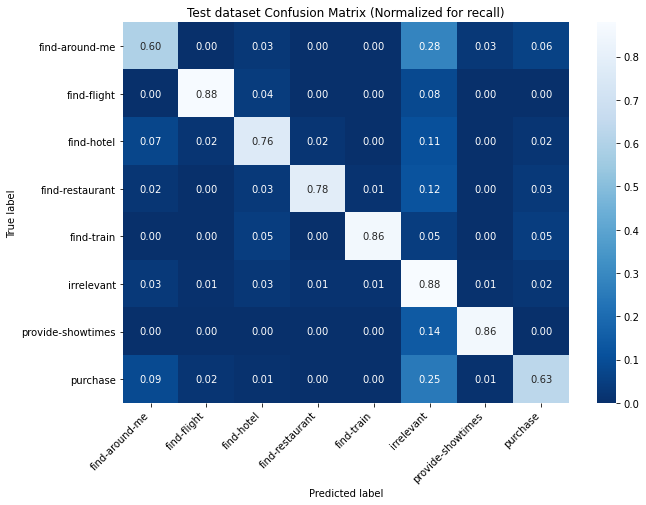

In [7]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

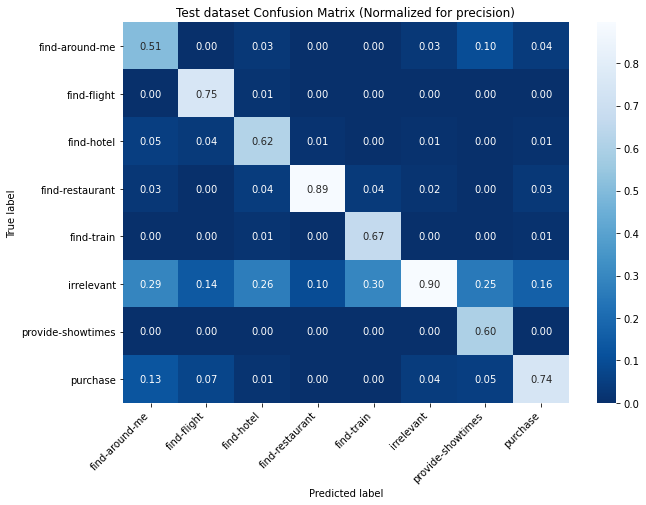

In [8]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On observe une précision presque identique au modèle d'origine néanmoins on remarquera que nous avons grandement amélioré le recall.
Cela nous intéresse puisque cette amélioration se traduit par une plus grande proportion d'intentions qui sont correctement décelées.
Les deux métriques tournent autour de 0.7-0.8 ce qui semble être un bon seuil d'utilisation afin d'avoir une expéreicne eutilisteur satisfaisante.
Plus concrètement, cela veut dire que l'utilisateur aura moins de frustration lorsqu'il tentera de lancer une action basée sur une intention, puisqu'auparavant il avait statistiquement 50% de chances que son intention soit reconnue, alors que maintenant il en a 70%.
Malgré tout, nous voulons faire en sorte d'essayer d'améliorer la précision qui reste un point déterminant de l'expérience utilisateur dans ce cas d'utilisation.
Pour y remédier, nous tentons alors de modifier notre prise de décision sur le retour du modèle en instaurant une fonction de seuil, qui introduit un pourcentage de certitude pour attribuer un label hors "irrelevant" au lieu de prendre la plus haute probabilité.

In [9]:
training_results = score(y_true_t, y_pred_t)

In [10]:
print(training_results['report'])
print("kappa score:", training_results['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.96      0.98      0.97       383
      find-flight       0.95      1.00      0.98       142
       find-hotel       0.96      1.00      0.98       316
  find-restaurant       0.99      0.99      0.99       469
       find-train       0.95      0.99      0.97       143
       irrelevant       1.00      0.99      0.99      3852
provide-showtimes       0.89      0.99      0.94       117
         purchase       0.99      0.97      0.98       613

         accuracy                           0.99      6035
        macro avg       0.96      0.99      0.97      6035
     weighted avg       0.99      0.99      0.99      6035

kappa score: 0.9759464663675748


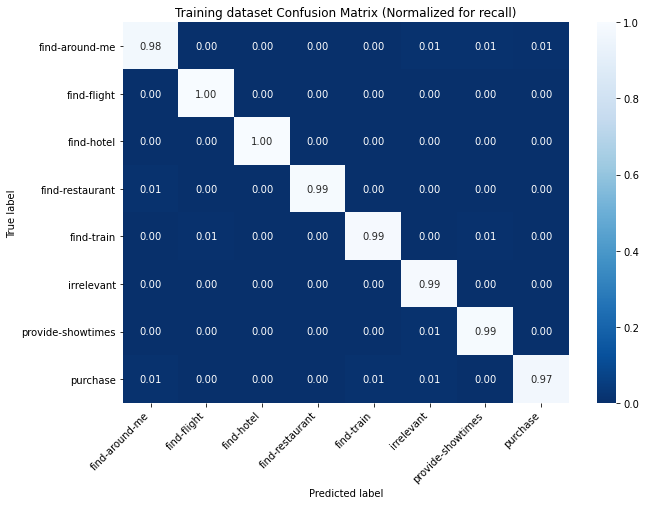

In [11]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Training dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

Nous voyons que notre modèle connait très bien les données d'entraînement, et est proche d'un score parfait avec un kappa score de presque à.98.
Malgré cela, les performances sur les données de test ne sont pas au même niveau, c'est de l'overfitting.
D'un autre côté, on se demande si en ajoutant un threshold pour lequel toutes les prédictions avec moins que ce threshold seront reclassées en ```irrelevant``` change quelque chose à nos résultats. 

In [12]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.5, "irrelevant")

In [13]:
testing_results_thresh = score(y_true, y_pred_thresh)

In [14]:
print(testing_results_thresh['report'])
print("kappa score:", testing_results_thresh['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.53      0.60      0.56        67
      find-flight       0.75      0.88      0.81        24
       find-hotel       0.63      0.75      0.68        55
  find-restaurant       0.89      0.77      0.83        93
       find-train       0.67      0.86      0.75        21
       irrelevant       0.88      0.88      0.88       677
provide-showtimes       0.60      0.86      0.71        14
         purchase       0.73      0.61      0.66       114

         accuracy                           0.82      1065
        macro avg       0.71      0.77      0.74      1065
     weighted avg       0.82      0.82      0.82      1065

kappa score: 0.6799495131626397


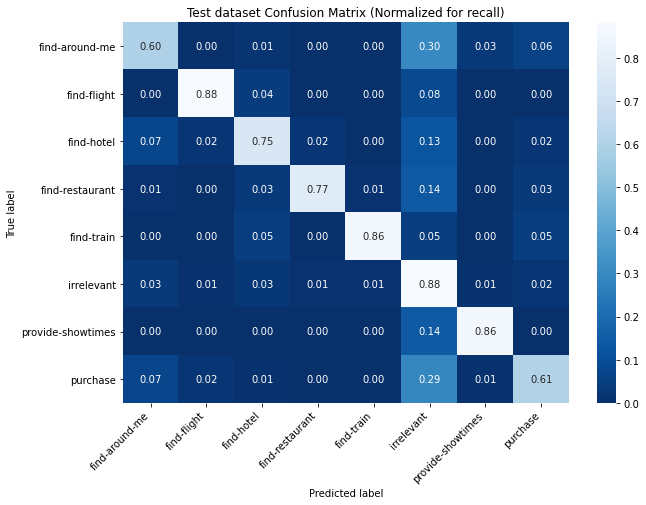

In [15]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

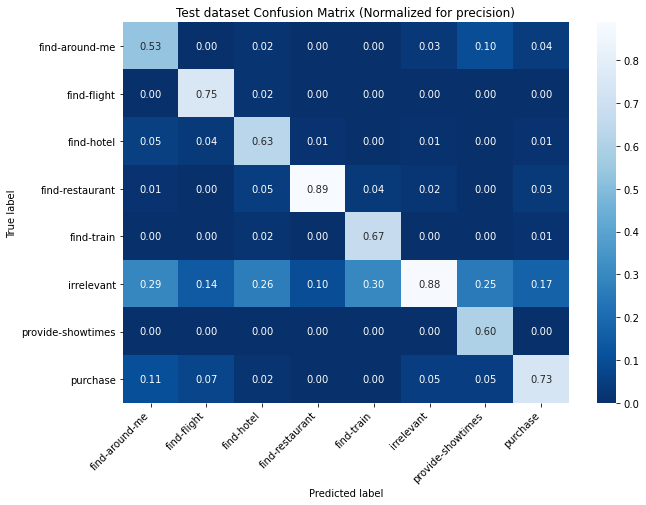

In [16]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On remarque que lorsqu'on fixe un threshold assez faible, à 0.5, les résultats sont identiques, ce qui indique que notre modèle fait ses choix avec une confiance assez importante.
Le kappa score entre autre est identique.

In [17]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.75, "irrelevant")
y_pred_t_thresh = predict_with_threshold(model, X_train, 0.75, "irrelevant")
training_results_thresh = score(y_true_t, y_pred_t_thresh)
testing_results_thresh = score(y_true, y_pred_thresh)
print(testing_results_thresh['report'])
print("kappa score:", testing_results_thresh['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.63      0.58      0.60        67
      find-flight       0.78      0.88      0.82        24
       find-hotel       0.65      0.67      0.66        55
  find-restaurant       0.92      0.72      0.81        93
       find-train       0.72      0.86      0.78        21
       irrelevant       0.85      0.91      0.88       677
provide-showtimes       0.65      0.79      0.71        14
         purchase       0.78      0.55      0.65       114

         accuracy                           0.82      1065
        macro avg       0.75      0.74      0.74      1065
     weighted avg       0.82      0.82      0.81      1065

kappa score: 0.6684923818325212


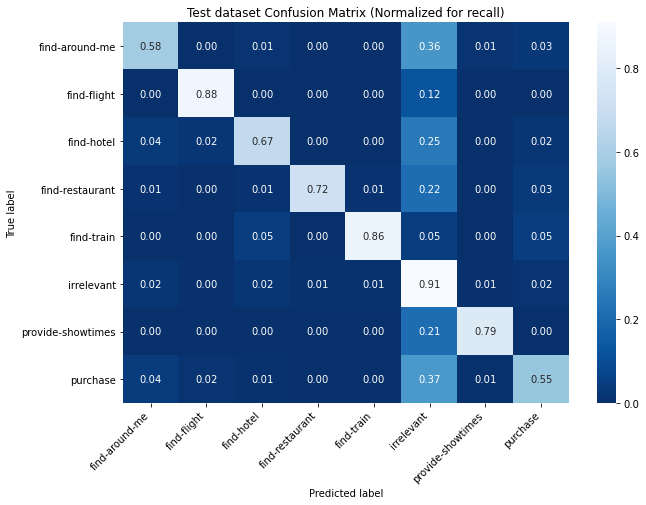

In [18]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

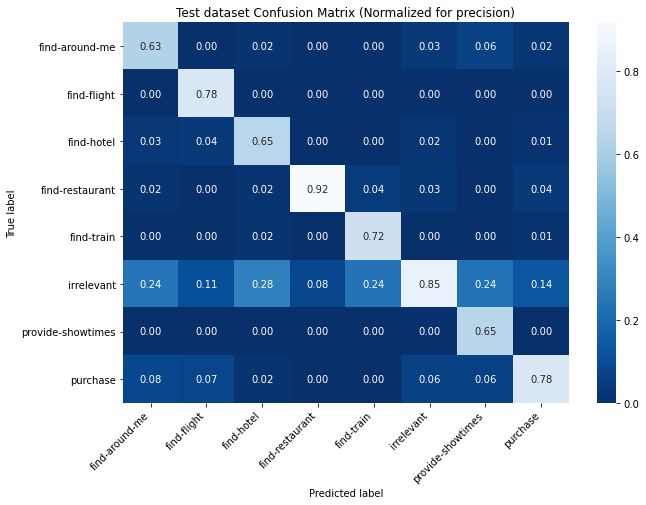

In [19]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

En essayant de monter le threshold à 0.75, on observe une légère amélioration de la précision sur l'ensemble des classes (hors ```irrelevant```), mais cette précision est contrebalancée par une diminution du recall et du kappa score. L'utilisation d'un theshold est donc un échec.

# Avec le jeu de données augmenté

Le training set a été augmenté pour certaines classes, de nouveaux exemples sont produits à partir des anciens exemples.
Ces nouveaux exemples sont générés en remplaçant les mots de type 'verbe' et 'nom' par les lemmes de leurs synonymes.
Nous pensons que bien que cela nous ne offre pas de meilleures performances sur le training set et le test set, si l'on arrive à garder les anciennnes performances, cela indiquera que ntore modèle est plus robuste.

In [20]:
raw_training_data = get_raw_training_data('./data/augmented_training_set.json')

for r in raw_training_data:
    if "message" in r:
        r["sentence"] = r["message"]

y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)

model = get_spacy_model(labels)

model = train(model, X_train, y_train, 18, test=(X_test, y_test))
model.to_disk(f"./model_augmented")

Training the model...
Iteration 0/18. train_loss: 20.335338463337393 test score:40.13236614180394%
Iteration 1/18. train_loss: 0.9961186170112342 test score:61.008455951675266%
Iteration 2/18. train_loss: 0.2007864091283409 test score:67.35685748630893%
Iteration 3/18. train_loss: 0.06337677345436532 test score:69.18893201117203%
Iteration 4/18. train_loss: 0.03915945636072138 test score:70.85183947060484%
Iteration 5/18. train_loss: 0.031996174808227806 test score:70.94291595369933%
Iteration 6/18. train_loss: 0.02389637084434071 test score:71.21292921890887%
Iteration 7/18. train_loss: 0.017110766114910803 test score:72.86439053211214%
Iteration 8/18. train_loss: 0.015253223443210118 test score:72.3136982499427%
Iteration 9/18. train_loss: 0.012176766248188642 test score:74.41671535139064%
Iteration 10/18. train_loss: 0.011045325528257877 test score:73.55675148165342%
Iteration 11/18. train_loss: 0.010406506128489923 test score:72.34770862403832%
Iteration 12/18. train_loss: 0.008345

In [21]:
y_pred = predict(model, X_test)

In [22]:
testing_results = score(y_true, y_pred)

In [23]:
print(testing_results['report'])
print("kappa score:", testing_results['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.67      0.48      0.56        67
      find-flight       0.81      0.92      0.86        24
       find-hotel       0.76      0.76      0.76        55
  find-restaurant       0.84      0.75      0.80        93
       find-train       0.78      0.86      0.82        21
       irrelevant       0.91      0.90      0.91       677
provide-showtimes       0.63      0.86      0.73        14
         purchase       0.68      0.82      0.74       114

         accuracy                           0.85      1065
        macro avg       0.76      0.79      0.77      1065
     weighted avg       0.85      0.85      0.84      1065

kappa score: 0.7303085562876277


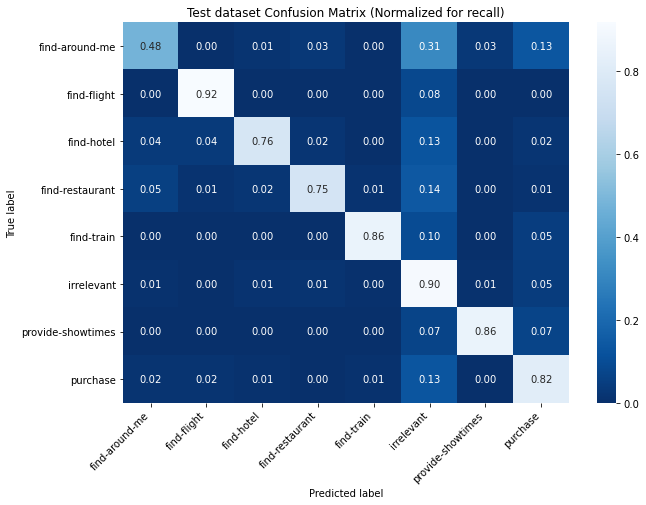

In [24]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

Les performances que nous obtenons avec ce modèle semblenet être légèrement meilleures que celle de notre modèle d'origine. 
Notre kappa score est 10% plus élevé et on gagne quelques points de précision.
Cependant, nous supposons que celui-ci serait capable de mieux généraliser pour des exemples sortant du dataset.

Nous avons également essayé de mettre en place de la classification hiérarchique en créant 2 modèles au lieu d'un seul : le premier attribuant le label "irrelevant" ou non. Si le label "irrelevant" n'est pas attribué, on donne alors la donnée au deuxième modèle qui lui attribue un label associé à une des classes d'intérêt.

In [25]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy_irrelevant(raw_training_data)
X_test, y_test = format_data_as_spacy_irrelevant(raw_testing_data)


irrelevant_model = get_spacy_irrelevant_model(labels)


irrelevant_model = train(irrelevant_model, X_train, y_train, 10, test=(X_test, y_test))
irrelevant_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 11.248104857535509 test score:82.71103896103897%
Iteration 1/10. train_loss: 0.5952975674445042 test score:84.40082023856023%
Iteration 2/10. train_loss: 0.12419555538144778 test score:84.44638336753493%
Iteration 3/10. train_loss: 0.040708074539452355 test score:85.8557800224467%
Iteration 4/10. train_loss: 0.017819441275378267 test score:84.63906859389063%
Iteration 5/10. train_loss: 0.013213247590840638 test score:86.41973651537218%
Iteration 6/10. train_loss: 0.01100960303250531 test score:85.43589743589743%
Iteration 7/10. train_loss: 0.0095500692214614 test score:86.37359163674954%
Iteration 8/10. train_loss: 0.008767508836672988 test score:85.47912539058498%
Iteration 9/10. train_loss: 0.0067705279378174055 test score:85.86550652719642%


In [26]:
raw_training_data_others = [r for r in raw_training_data if r['intent'] != "irrelevant"]
raw_testing_data_others = [r for r in raw_testing_data if r['intent'] != "irrelevant"]

others_y_true = [r['intent'] for r in raw_testing_data if r['intent'] != "irrelevant"]
others_y_true_t = [r['intent'] for r in raw_training_data if r['intent'] != "irrelevant"]

X_train, y_train = format_data_as_spacy_others(raw_training_data_others)
X_test, y_test = format_data_as_spacy_others(raw_testing_data_others)

others_model = get_spacy_others_model(labels)

others_model = train(others_model, X_train, y_train, 10, test=(X_test, y_test))
others_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.19739415193908 test score:54.55532243145292%
Iteration 1/10. train_loss: 3.0604508366668597 test score:69.96326488275668%
Iteration 2/10. train_loss: 0.9058232235547621 test score:79.61543193388621%
Iteration 3/10. train_loss: 0.3174318457558911 test score:83.03474435447387%
Iteration 4/10. train_loss: 0.13854279169299843 test score:83.90839080290228%
Iteration 5/10. train_loss: 0.05627603329571684 test score:84.14873462587914%
Iteration 6/10. train_loss: 0.030706722375725803 test score:85.69967710170727%
Iteration 7/10. train_loss: 0.014430514663530403 test score:86.44566182119107%
Iteration 8/10. train_loss: 0.00748578713270831 test score:87.0447317252153%
Iteration 9/10. train_loss: 0.005214605965988994 test score:85.99158452470631%


In [27]:
X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)

y_pred_irr = predict(irrelevant_model, X_test)
y_pred_t_irr = predict(irrelevant_model, X_train)

X_train = [X_train[i] for i in range(len(X_train)) if y_pred_t_irr[i] == 'relevant']
X_test = [X_test[i] for i in range(len(X_test)) if y_pred_irr[i] == 'relevant']

y_pred_oth = predict(others_model, X_test)
y_pred_t_oth = predict(others_model, X_train)
y_pred = []
others_ind = 0
for i in range(len(y_pred_irr)):
    if y_pred_irr[i] == 'irrelevant':
        y_pred.append(y_pred_irr[i])
    else:
        y_pred.append(y_pred_oth[others_ind])
        others_ind += 1


y_pred_t = []
others_ind = 0
for i in range(len(y_pred_t_irr)):
    if y_pred_t_irr[i] == 'irrelevant':
        y_pred_t.append(y_pred_t_irr[i])
    else:
        y_pred_t.append(y_pred_t_oth[others_ind])
        others_ind += 1


In [28]:
testing_results = score(y_true, y_pred)
print(testing_results['report'])
print("kappa score:", testing_results['kappa'])

                   precision    recall  f1-score   support

   find-around-me       0.54      0.64      0.59        67
      find-flight       0.84      0.88      0.86        24
       find-hotel       0.68      0.78      0.73        55
  find-restaurant       0.84      0.80      0.82        93
       find-train       0.82      0.86      0.84        21
       irrelevant       0.91      0.88      0.89       677
provide-showtimes       0.71      0.71      0.71        14
         purchase       0.68      0.70      0.69       114

         accuracy                           0.83      1065
        macro avg       0.75      0.78      0.77      1065
     weighted avg       0.84      0.83      0.83      1065

kappa score: 0.7088665843535153


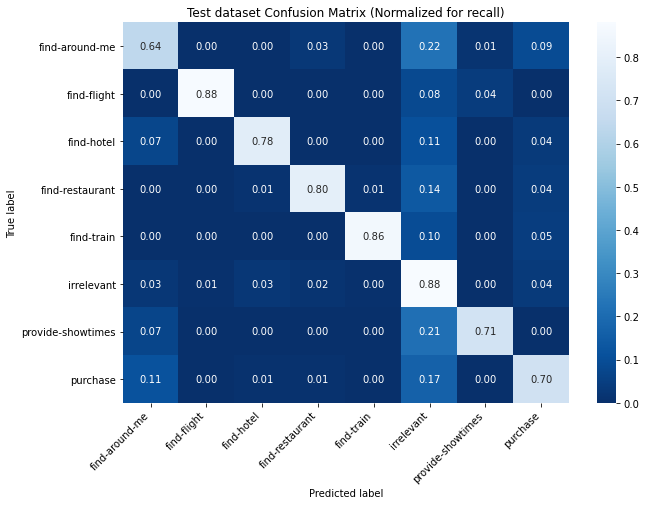

In [29]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

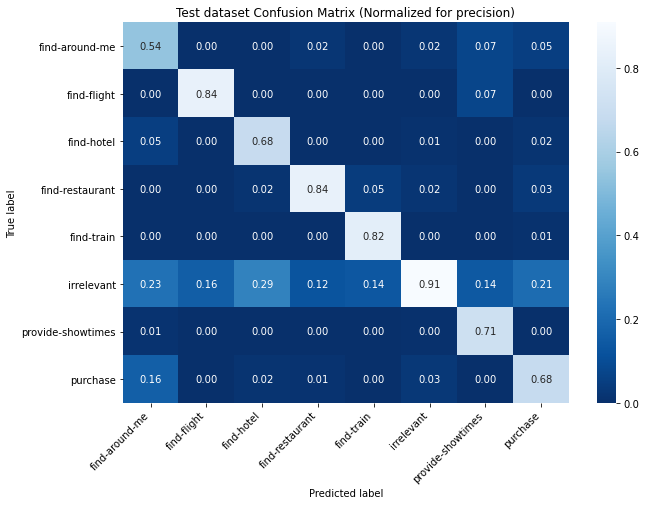

In [30]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On constate en utilisant cette classification hiérarchique les performances dans l'ensemble ne sont, encore une fois, pas très différentes. Sur plusieurs exécutions, nous observions parfois un meilleur recall ou une meilleur précision mais ce n'est pas une tendance générale et systématique. Nous pensons donc que cela découle seulement de l'aléatoire associé à l'entrainement ("Lottery Ticket Hypothesis").

Nous décidons de garder le modèle que nous avons entrainé sur le jeu de données augmenté.
D'abord, parce qu'il est probablement plus robuste et généralise mieux, puis parce qu'il offre des performances aux moins égales aux autres méthodes.